# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year].tsv``, ``positive_validation_after_{year}_pahse_4.tsv``, ``negative_prediction_after_{year}_phase_4.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [2]:
target_year = 2014
num_years_later = 6

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")

embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 234512 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2014.npy and ../data/embeddings_final/words_SG_upto2014.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,-4.980139,-4.249372,-3.656294,-0.215405,-2.485486,-4.880480,0.569936,3.525534,-2.735071,2.929585,...,-1.911128,2.332488,-3.243119,4.112899,6.347937,-2.990223,4.258698,0.921466,-2.977834,-3.045444
patient,-4.358530,-4.682502,-4.189298,0.179848,-3.057365,-6.224209,0.564190,3.037076,-2.552714,4.893758,...,-1.628182,3.522367,-3.043320,2.598499,6.041109,-3.980612,4.440180,2.494890,-2.716677,-3.416752
meshd009369,-3.452896,-2.313226,-4.002501,-0.055844,-2.634709,-5.457378,2.182188,4.629396,-2.170140,4.443802,...,-1.260485,2.104979,-2.468472,3.616910,6.384088,-4.817503,3.437115,0.201313,-1.298782,-2.774735
study,-3.292896,-4.693490,-3.970751,-0.060601,-3.843336,-5.938642,0.274612,3.269480,-3.298679,3.570080,...,-1.680222,3.518521,-3.028906,3.791364,6.290039,-3.225273,4.156088,2.306020,-1.768331,-4.321453
0,-4.786961,-5.267066,-3.948454,0.114782,-3.806814,-6.008698,0.354302,3.986808,-2.879348,5.374468,...,-1.407016,1.880640,-4.056701,2.019548,6.047293,-3.338437,3.639134,2.112144,-1.183349,-4.508092
1,-4.602722,-4.102684,-3.856936,0.102188,-3.808176,-6.234705,0.433967,3.451885,-3.376763,5.740398,...,-1.690624,1.028860,-3.714723,1.761134,6.401217,-3.334288,3.566628,2.315960,-1.486821,-2.868295
use,-5.273597,-3.675604,-3.733992,-0.540895,-3.173968,-7.210793,0.854399,3.138489,-3.250750,3.147972,...,-1.641924,3.309921,-4.030232,4.909722,6.351670,-3.540069,3.175005,2.209906,-2.339851,-3.840097
2,-4.656091,-3.988115,-3.825408,0.095735,-3.932255,-6.569601,0.198396,3.218995,-3.709795,5.808820,...,-1.617544,1.608812,-3.361573,2.266476,6.565827,-3.141440,3.522556,2.079819,-1.926957,-2.978841
treatment,-4.441556,-5.091295,-3.988740,-0.127149,-3.734644,-6.880018,-0.468065,5.039606,-2.906109,5.008976,...,-1.278469,2.690426,-2.885372,4.065932,5.885737,-3.018400,3.511767,1.525648,-1.770803,-3.533768
case,-5.404951,-3.002605,-4.327097,0.242841,-2.333820,-5.229801,0.887384,3.956260,-2.225265,4.664158,...,-1.701103,3.534135,-3.669200,3.440076,7.362900,-3.177783,4.788403,2.113996,-2.838747,-3.045693


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  234512


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples =  "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd002289,ncbigene1956
1,meshd002289,ncbigene2064
2,meshd002289,ncbigene2066
3,meshd007938,ncbigene25
4,meshd007938,ncbigene11183


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

307 positive examples
234512 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 246 kinase-cancer difference vectors
[INFO]	Initial data: 307 examples
[INFO]	Could not identify 1 gene ids
[INFO]	Could not identify 1 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd002289,0.084409,-1.678300,0.570391,-0.568099,-0.010835,0.572113,-0.322410,0.739851,1.520667,2.166842,...,-0.575982,-1.295671,1.546393,1.501823,0.745674,-0.125327,0.032880,-0.964539,-1.653759,-1.042141
ncbigene2064-meshd002289,-0.369026,-0.722960,0.209369,-1.060191,0.139762,0.383901,-0.069822,0.742758,1.055592,2.474284,...,-0.220842,-1.920477,1.655190,0.945728,0.002300,0.255939,0.853816,-0.957237,-1.405988,-1.630018
ncbigene2066-meshd002289,-0.043715,-0.862368,0.478816,-1.063887,1.431216,1.833705,-0.942973,0.174733,2.030440,1.787186,...,0.007926,-1.074296,0.527892,0.213083,0.165353,0.056865,-0.640007,-0.653880,-1.129007,0.028811
ncbigene25-meshd007938,-0.409652,-0.704031,0.943865,-0.178671,-0.030556,-0.388466,0.692359,-0.573274,-1.647355,1.072487,...,-0.652975,0.923524,1.529238,1.960512,-0.228658,0.389493,0.665099,0.897752,-1.024783,-0.170860
ncbigene11183-meshd007938,2.941060,1.268534,3.065635,0.826578,1.332825,3.187913,-0.649064,0.081814,1.900195,-0.112945,...,1.272254,-1.298478,3.419828,-0.214624,-2.752574,1.857538,-2.017282,-0.098772,1.099827,1.982624


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

246 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd014523,ncbigene1445
1,meshd008039,ncbigene5291
2,meshd004416,ncbigene2475
3,meshd012513,ncbigene5598
4,meshd036821,ncbigene8550


In [12]:
print("%d negative examples" % len(negative_df))

2560 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 2225 kinase-cancer difference vectors
[INFO]	Initial data: 2560 examples
[INFO]	Could not identify 27 gene ids
[INFO]	Could not identify 51 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1445-meshd014523,0.103116,0.514359,0.629539,-0.699788,1.437126,0.447069,-1.185853,-0.392177,-0.273439,0.024817,...,0.224437,-0.886441,-0.088779,-0.013493,0.216561,-0.532029,-0.765772,0.573051,-0.402464,0.484443
ncbigene5291-meshd008039,-0.765362,0.106615,-0.075918,-0.057398,-0.251506,0.060982,-0.344138,-0.785687,-1.246830,-0.592007,...,0.250893,-0.387700,0.079291,0.381052,-0.438861,-0.965877,1.042025,-1.225918,-0.441799,0.618339
ncbigene2475-meshd004416,-0.955311,-1.276262,0.413071,0.544433,-0.319281,-1.566490,0.168395,-0.021670,-1.183257,-0.098914,...,-1.436414,2.287161,-0.806313,0.036829,-0.889310,-3.030403,1.222007,-0.945954,-0.985793,1.076411
ncbigene5598-meshd012513,-1.042673,-0.929378,-0.102725,-0.428108,-0.413165,-0.160160,0.002246,0.346924,-0.427256,0.436690,...,-1.473512,0.795577,-0.337472,0.437916,0.849957,-0.743332,0.782996,0.379505,-1.909414,0.310865
ncbigene8550-meshd036821,0.750986,-0.083702,1.466731,0.298107,-0.188651,-0.286539,-0.658407,-0.588635,0.335198,-1.408496,...,1.254997,-1.230230,0.459749,-0.271260,-1.335422,0.273981,-0.574885,-0.837217,0.821524,0.244015


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=246) and negative (n=2225) to the combined dataframe (2471)


In [16]:
X_train.values

array([[ 0.08440852, -1.6783001 ,  0.57039094, ..., -0.9645392 ,
        -1.6537595 , -1.042141  ],
       [-0.36902642, -0.72296023,  0.2093687 , ..., -0.95723665,
        -1.4059885 , -1.6300178 ],
       [-0.043715  , -0.8623681 ,  0.47881627, ..., -0.65387964,
        -1.1290073 ,  0.0288105 ],
       ...,
       [ 1.2086885 , -1.1349249 ,  0.6596205 , ...,  0.1863817 ,
         0.11408782,  0.30774117],
       [ 0.7853534 , -0.2958902 ,  1.3609898 , ..., -1.0120866 ,
         0.07588792,  0.83038974],
       [-0.2030158 , -1.2363014 ,  0.88221836, ..., -0.09835541,
        -1.16829   ,  0.3158126 ]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.637117   0.04398105 0.03298842]


Text(0, 0.5, 'PC 2 (4.40%)')

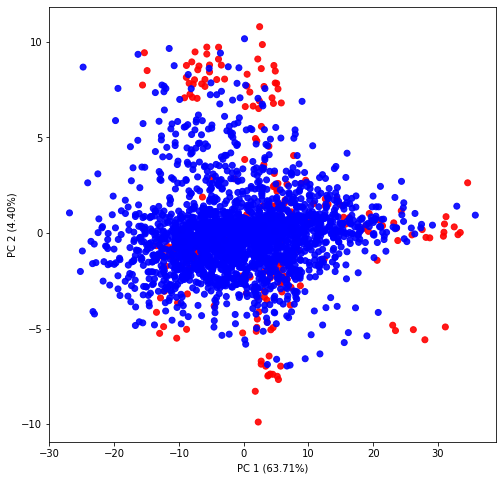

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2471 samples in 0.001s...
[t-SNE] Computed neighbors for 2471 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2471
[t-SNE] Computed conditional probabilities for sample 2000 / 2471
[t-SNE] Computed conditional probabilities for sample 2471 / 2471
[t-SNE] Mean sigma: 0.988053
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.954811
[t-SNE] KL divergence after 300 iterations: 1.104039
t-SNE done! Time elapsed: 7.125524997711182 seconds


Text(0, 0.5, 'tsne-2d-two')

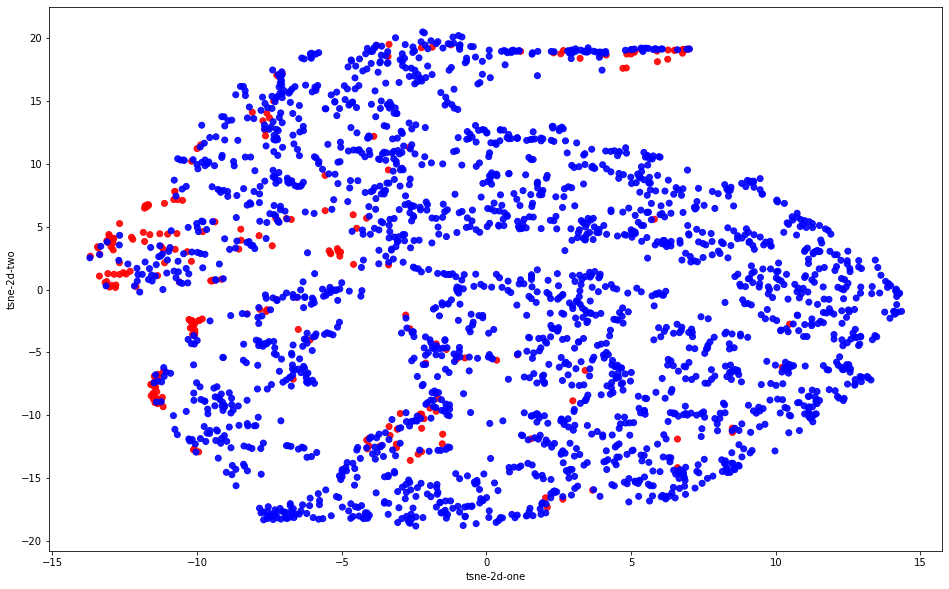

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (2471, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 246, number of negative examples: 2225, Y_train.shape: (2471,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}_phase4.tsv".format(num_years_later, target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd055756,ncbigene83942
1,meshd055756,ncbigene4233
2,meshd018303,ncbigene5604
3,meshd018231,ncbigene2475
4,meshd005870,ncbigene1436


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 68 kinase-cancer difference vectors
[INFO]	Initial data: 74 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 2 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene83942-meshd055756,1.601934,1.926442,2.091786,-0.765604,1.694290,2.502961,-0.882266,-2.817492,0.693951,-3.020826,...,1.306040,-1.150689,1.123322,-1.888740,-4.220824,1.465172,-2.000115,-1.237209,0.871192,1.298638
ncbigene4233-meshd055756,0.499305,-0.748052,0.398244,-1.193417,-0.235730,-0.235352,0.428456,-0.071562,-1.240272,-0.071715,...,-0.929017,0.551845,0.647178,0.198003,-0.443651,-1.465547,0.192123,0.009982,-1.032457,-0.593653
ncbigene5604-meshd018303,-0.227589,-3.134366,1.301930,-0.497991,-1.231070,-1.239594,-1.198330,0.216627,-1.195087,-0.885405,...,-0.156518,-0.891367,0.034141,1.167147,-0.074914,-1.100232,-0.054568,0.162252,-1.646078,0.465531
ncbigene2475-meshd018231,-1.327072,-1.717465,0.151936,0.189436,-0.713341,-1.245764,-0.080396,-1.222974,-2.076231,0.556080,...,-0.325895,-0.194400,0.825383,1.920159,-0.505583,-1.399949,2.169877,0.344920,-0.846932,-0.191632
ncbigene1436-meshd005870,0.633223,-0.682253,0.541518,-1.194870,-0.796463,-0.196831,-0.917014,-0.754587,-0.428526,-0.470160,...,-0.015774,-1.351537,0.644365,-1.317160,-1.696386,-1.222083,-0.110928,-0.164664,-0.677044,0.592104


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_{}_years_after_{}_phase4.tsv".format(num_years_later, target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd006392,ncbigene84033
1,meshd018316,ncbigene65061
2,meshd015479,ncbigene6195
3,meshd018206,ncbigene9943
4,meshd009382,ncbigene6348


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 2260 kinase-cancer difference vectors
[INFO]	Initial data: 2560 examples
[INFO]	Could not identify 27 gene ids
[INFO]	Could not identify 51 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene84033-meshd006392,1.035556,-0.095379,1.648698,-0.082920,0.261301,1.097234,-1.813444,-1.291546,0.222416,-1.539922,...,0.609393,-1.526969,0.571495,-1.385694,-2.263855,0.266354,-0.361196,-2.203984,0.913646,0.850428
ncbigene65061-meshd018316,2.624291,1.159480,2.366224,-0.638873,0.888651,3.036588,-1.477770,-2.911571,0.816985,-3.555645,...,1.799036,-1.762368,2.240374,-2.020268,-5.154717,1.813153,-2.231879,-0.397073,0.450937,1.016716
ncbigene6195-meshd015479,0.274534,-1.573993,1.243437,0.420470,0.170501,0.360835,-0.481452,1.154335,0.159979,-0.005248,...,0.392275,-0.402595,1.185596,0.234450,-0.247137,-0.549432,0.640935,-0.111964,-0.526512,0.981192
ncbigene9943-meshd018206,0.855141,-0.121510,1.696743,-0.035411,0.241917,0.580430,-0.924494,-1.454325,0.327013,-1.887857,...,1.591729,-1.543363,1.174882,-0.529872,-2.682834,0.565922,-0.664498,-1.078608,-0.388711,1.240465
ncbigene6348-meshd009382,1.137295,-1.006769,0.029724,-0.593868,-0.895469,0.870538,-0.399446,0.003197,-1.569848,0.517142,...,0.161993,0.183511,-0.923713,-0.547291,-0.167440,-0.033332,-0.995054,0.135738,0.451367,0.299216


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}-phase4.pkl".format(num_years_later, target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path = "positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path = "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}-years-after-{}-phase4.pkl".format(num_years_later, target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)